# EAA Winter School in Computational Acoustics 2018


## An introduction to 1D Finite-Element 

The objective of this first tutorial is to 
 1. do your first finite-element model
 2. test linear and quadratic finite-elements
 3. make your first convergence curves


### Preamble

We begin by loading a number of standard modules such as `numpy` and `matplotlib`. We also adjust some default parameters of figures.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.sparse.linalg import eigs

In [54]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=14)
mpl.rc('axes', linewidth=1.5, labelsize=14)
mpl.rc('legend', fontsize=14)

### Definition of the problem

We consider the 1D propagation in a tube. It is governed by the Helmholtz equation:
$$
p''(x)
+ \dfrac{\omega^2}{c_0^2} p(x)
= 0 \textrm{ in } \Omega.
$$
where $p(x)$ is the acoustic pressure and $\Omega=]-L;0[$ is the geometrical domain associated to the tube. The weak form associated to this problem is 
$$ 
\forall q\in V,\quad \Big[
p'(x)q(x)
\Big]_{-L}^0 - \displaystyle{\int_{-L}^0} p'(x)q'(x)dx + \dfrac{\omega^2}{c_0^2} \displaystyle{\int_{-L}^0} p(x)q(x)dx =0 
$$
$V$ is the space in which both physical and test functions belongs.  At the boundary of the domain, several different conditions can be considered. In the case of this first practice, we will consider both ends of the tube are closed so that the derivative of the pressure are zero ($p'(-L)=p'(0)=0$). The weak form then becomes:
$$ 
\forall q\in V,\quad \displaystyle{\int_{-L}^0} p'(x)q'(x)dx - \dfrac{\omega^2}{c_0^2} \displaystyle{\int_{-L}^0} p(x)q(x)dx =0 
$$

### Computation of modes of the tube

We will compute, by the Finite-Element Method the modes of the cavity. We know that analytically the possible values are discrete and given by:
$$ \omega_n=c_0\dfrac{n\pi}{L},\quad n\in\mathbb{N}$$. So as to simplify the analysis, without loss of generality, we will consider that the celerity is unity $c_0=1$ and that the length of the tube is $L=\pi$:

In [55]:
c_0 = 340
L=np.pi * c_0

### Discretisation by a single linear element

We will implement the FEM for a single linear element. The size$\delta$ of the element is the equal to the length $L$ of the domain. On the whole domain (element), the pressure and the test functions are assumed to be linear:
$$ p(x)=p_1N_1(x)+p_2N_2(x),\quad N_1(x)=1-\dfrac{x}{\delta},\quad N_2(x)=\dfrac{x}{\delta},$$
where $p_1$ and $p_2$ are the two degrees of freedom. $N_1$ and $N_2$ are called the shape functions and links the approximation of the function in each point $x$ of the element as a function of the unknowns $p_1$ and $p_2$.



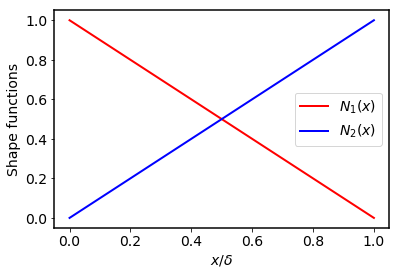

In [56]:
delta = L
x = np.linspace(0,delta,200)
plt.figure()
plt.plot(x/delta,1-x/delta,'r',label='$N_1(x)$')
plt.plot(x/delta,x/delta,'b',label='$N_2(x)$')
plt.xlabel('$x/\delta$');plt.ylabel('Shape functions')
plt.legend()
plt.show()

><div class="alert alert-block alert-info">
If the two nodes $x=0$ and $x=L$ are respectively denoted by $x_1$ and $x_2$, what is the value of 
$ \phi_k(x_k)$ ? What is then the significance of $p_1$ and $p_2$ ?



A similar approximation is considered for the test field $q$: 
$$ q(x)=q_1N_1(x)+q_2N_2(x).$$

The weak form is then approximated as:
$$ 
\forall q_1,q_2\in \mathbb{R},\quad 
\{q_1,\,q_2\} \Big(
[\boldsymbol{K}_e(L)]-k^2[\boldsymbol{M}_e(L)]\Big)\begin{Bmatrix}p_1\\p_2
\end{Bmatrix}
=0 
$$
with:
$$ [\boldsymbol{K}_e(\delta)]=\dfrac{1}{\delta}\begin{bmatrix}1&-1\\-1&1\end{bmatrix},\quad [\boldsymbol{M}_e(\delta)]=\dfrac{\delta}{6c_0^2}\begin{bmatrix}2&1\\1&2\end{bmatrix}.$$
The expressions of the matrices are given for the moment. We will see in another notebook how to compute them.

In [57]:
def K_e(delta):
    return (1/delta)*np.array([[1.,-1.],[-1.,1.]])

def M_e(delta):
    return (delta/(6.*c_0**2))*np.array([[2.,1.],[1.,2.]])

$\omega^2$ are the eigenvalues of the generalised eigenvalue problem:
$$ [\boldsymbol{K}_e(\delta)]\begin{Bmatrix}p_1\\p_2
\end{Bmatrix}=\omega^2[\boldsymbol{M}_e(\delta)]\begin{Bmatrix}p_1\\p_2
\end{Bmatrix}.$$

In [58]:
omega = np.sqrt(eig( K_e(L), M_e(L),left=False,right=False))
print(omega)

[5.10434207e-17+0.j 1.10265779e+00+0.j]


><div class="alert alert-block alert-info">
We then obtain two eigenvalues. The first one is zero, explain why. The second is an approximation of $1$ (as $L=\pi$). What is the level of the error ?

### Discretisation by several linear elements:

We will now consider the discretisation by $n$ linear elements. $\Omega$ is divided in $n$ subdomains of length $\delta=L/n$ on which a linear approximation of the physical and test function is considered. The pressure at the $n+1$ nodes are respectively denoted by $p_0$ ... $p_n$ and the weak form is:
$$ 
\forall q_1,...,q_n\in \mathbb{R},\quad \displaystyle{\sum_{j=1}^n}
\{q_{j-1},\,q_{j}\} \Big(
[\boldsymbol{K}_e(\delta)]-\omega^2[\boldsymbol{M}_e(\delta)]\Big)\begin{Bmatrix}p_{j-1}\\p_j
\end{Bmatrix}
=0.$$

><div class="alert alert-block alert-info">
What are, formally, the global matrices $[\boldsymbol{H}]$ and $[\boldsymbol{Q}]$ so that the weak form is approximated by:
$$ 
\forall q_0,...,q_{n}\in \mathbb{R},\quad 
\{q_1,\,...,q_n\} \Big(
[\boldsymbol{K}]-\omega^2[\boldsymbol{M}]\Big)\begin{Bmatrix}p_0\\\vdots \\p_n
\end{Bmatrix}
=0?$$

The implementation for $n$ elements is:

In [59]:
n =7
delta = L/n
K =np.zeros((n+1,n+1))
M =np.zeros((n+1,n+1))
for ie in range(n): # loop on the elements
    dof = slice(ie, ie+2) # indices of the local dofs
    K[dof,dof] += K_e(delta)
    M[dof,dof] += M_e(delta)
omega = np.sort(np.sqrt(eigs(K, 3, M,which='SM',return_eigenvectors=False)))
print(omega)

[0.        +6.35536184e-15j 1.00841229+0.00000000e+00j
 2.06762833+0.00000000e+00j]


You can modify the value of $n$ in the previous cell to investigate the evolution of the solution with respect to the discretisation.

><div class="alert alert-block alert-info">
How many elements do we need to have a precision of 1\% for the first eigenvalue ? Same question for the second eigenvalue.

### Discretisation by a single quadratic element

We will now consider quadratic elements and will consider the case of a single element of length $\delta=L$. On this element, the pressure is approximated by a second order function:
$$ p(x)=p_1N_1(x)+p_2N_2(x)+p_3N_3(x), $$
where $p_1$, $p_2$ and $p_3$ are the three degrees of freedom. A similar interpolation is considered for the test-function.

The shape functions are:
$$ N_1(x)=\dfrac{(x-\delta/2)(x-\delta)}{\delta^2/2},\quad N_2(x)-\dfrac{x(x-\delta)}{\delta^2/4},\quad N_3(x)=\dfrac{(x)(x-\delta)}{\delta^2/2}.$$

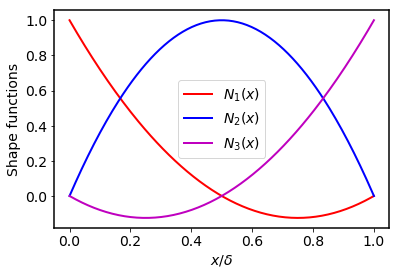

In [44]:
delta = L
x = np.linspace(0,delta,200)
plt.figure()
plt.plot(x/delta,(2/delta**2)*(x-delta/2)*(x-delta),'r',label='$N_1(x)$')
plt.plot(x/delta,-(4/delta**2)*x*(x-delta),'b',label='$N_2(x)$')
plt.plot(x/delta,(2/delta**2)*x*(x-delta/2),'m',label='$N_3(x)$')
plt.xlabel('$x/\delta$');plt.ylabel('Shape functions')
plt.legend()
plt.show()

><div class="alert alert-block alert-info">
If the two nodes $x=0$, $x=L/2$ and $x=L$ are respectively denoted by $x_1$, $x_2$ and $x_3$, what is the value of 
$ \phi_k(x_k)$ ? What is then the significance of $p_1$, $p_2$ and $p_3$ ?

The weak form for the discretisation by one quadratic element is:

$$ 
\forall q_1,q_2,q_3\in \mathbb{R},\quad 
\{q_1,\,q_2,q_3\} \Big(
[\boldsymbol{K}_e'(\delta)]-k^2[\boldsymbol{M}_e'(\delta)]\Big)\begin{Bmatrix}p_1\\p_2\\p_3
\end{Bmatrix}
=0 
$$
with:
$$ [\boldsymbol{K}_e'(\delta)]=\dfrac{1}{3\delta}\begin{bmatrix}7&-8&1\\-8&16&-8\\1&-8&7\end{bmatrix},\quad [\boldsymbol{M}_e'(\delta)]=\dfrac{\delta}{30c_0^2}\begin{bmatrix}
4& 2& -1 \\2 &16& 2\\-1& 2 &4
\end{bmatrix}.$$
 

In [45]:
def K_e_quad(delta):
    return (1/(3*delta))*np.array([[7.,-8.,1],[-8.,16.,-8],[1.,-8.,7]])

def M_e_quad(delta):
    return (delta/(30.*c_0**2))*np.array([[4.,2.,-1],[2.,16.,2],[-1,2,4]])

Let compute the first two values of $\omega$:

In [46]:
omega = np.sort(np.sqrt(eig( K_e_quad(L), M_e_quad(L),left=False,right=False)))
print(omega)

[0.        +5.42669357e-09j 1.10265779+0.00000000e+00j
 2.46561778+0.00000000e+00j]


><div class="alert alert-block alert-info">
Explain why the first (non-zero) eigenvalue is the same than the one computed for a single linear element.


The assembly of $n$ quadratic elements is as follows. The total number of degrees of freedom is $2n+1$.

In [47]:
n =2
delta = L/n
K =np.zeros((2*n+1,2*n+1))
M =np.zeros((2*n+1,2*n+1))

for ie in range(n): # loop on the elements
    dof = slice(2*ie, 2*ie+3) # indices of the local dofs
    K[dof,dof] += K_e_quad(delta)
    M[dof,dof] += M_e_quad(delta)
omega = np.sort(np.sqrt(eigs(K, 2, M,which='SM',return_eigenvectors=False)))
print(omega)    
    

[8.49625199e-09+0.j 1.00375412e+00+0.j]


><div class="alert alert-block alert-info">
To have a global problem with 5 degrees of freedom, we can either choose to discretise by 4 linear elements or by 2 quadratic elements. What is the best choice? Explain why.

### Convergence, first approach

We will now consider the convergence of the method which is the quality of the approximation as a function of the number of degrees of freedom. Two functions are first defined:

In [48]:
def error_lin(n):
    delta = L/n
    K =np.zeros((n+1,n+1))
    M =np.zeros((n+1,n+1))
    for ie in range(n): # loop on the elements
        dof = slice(ie, ie+2) # indices of the local dofs
        K[dof,dof] += K_e(delta)
        M[dof,dof] += M_e(delta)
    omega = np.sort(np.sqrt(eigs(K, 2, M,which='SM',return_eigenvectors=False)))    
    return(omega[1].real-c_0*np.pi/L)
    
def error_quad(n):    
    delta = L/n
    K =np.zeros((2*n+1,2*n+1))
    M =np.zeros((2*n+1,2*n+1))

    for ie in range(n): # loop on the elements
        dof = slice(2*ie, 2*ie+3) # indices of the local dofs
        K[dof,dof] += K_e_quad(delta)
        M[dof,dof] += M_e_quad(delta)
    omega = np.sort(np.sqrt(eigs(K, 2, M,which='SM',return_eigenvectors=False)))
    return (omega[1].real-c_0*np.pi/L)

For 5 linear elements, the error is:

In [49]:
print(error_lin(5))

0.016520017861562764


What can we say the error when the number of degrees of freedom is multiplied by 2 for linear and quadratic elements

In [50]:
n = 10
print(error_lin(n)/error_lin(2*n))
print(error_quad(n)/error_quad(2*n))

4.0035558886617295
15.938386101118994


### Convergence curves

We will now consider the convergence of the method which is the quality of the approximation as a function of the number of degrees of freedom.

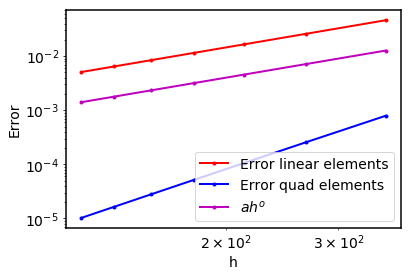

In [52]:
n_max = 10
h=np.zeros(n_max)
eps_lin=np.zeros(n_max)
eps_quad=np.zeros(n_max)

for i_n in range(3,n_max):
    h[i_n] = L/i_n
    eps_lin[i_n]=error_lin(i_n)
    eps_quad[i_n]=error_quad(i_n)
    
plt.figure()
plt.loglog(h,eps_lin,'r.-',label='Error linear elements')
plt.loglog(h,eps_quad,'b.-',label='Error quad elements')
a = 1e-7
o = 2
plt.loglog(h,a*h**o,'m.-',label='$ah^o$')
plt.xlabel('h') ; plt.ylabel('Error')
plt.legend()
plt.show()

The order $o$ of a method is defined as $ \epsilon \propto h^{o},$ where $h$ is the mesh size and $\epsilon$ is the error. You can modify the values of a and p in the previous script

><div class="alert alert-block alert-info">
What are the orders of linear and quadratic FEM ?